# Systematically Increasing size of ESN reservoir

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Define ESN class for feature extraction
class ESN(nn.Module):
    def __init__(self, input_size, reservoir_size, output_size, spectral_radius=0.9):
        super(ESN, self).__init__()
        self.input_size = input_size
        self.reservoir_size = reservoir_size
        
        # Initialize reservoir weights
        self.Win = nn.Parameter(torch.randn(reservoir_size, input_size))
        self.W = nn.Parameter(torch.randn(reservoir_size, reservoir_size))
        
        # Scaling W to have spectral radius = spectral_radius
        self.W.data *= spectral_radius / torch.max(torch.abs(torch.linalg.eigvals(self.W)))
        
        # Output layer
        self.Wout = nn.Linear(reservoir_size, output_size)
        
    def forward(self, input_data, initial_state=None):
        if initial_state is None:
            state = torch.zeros((input_data.size(0), self.reservoir_size)).to(input_data.device)
        else:
            state = initial_state

        state = torch.tanh(torch.matmul(input_data, self.Win.t()) + torch.matmul(state, self.W.t()))
        state = self.Wout(state)
        return state

# Define neural network class for prediction
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

final_result = []
for multiplier in np.linspace(1, 11, 20):
    # Instantiate ESN for feature extraction
    input_size = 28*28  # MNIST image size
    reservoir_size = multiplier*input_size  # Size of reservoir
    output_size_esn = input_size  # Output size of ESN (features)
    esn = ESN(input_size, reservoir_size, output_size_esn)

    # Instantiate neural network for prediction
    hidden_size = 100
    output_size_nn = 10
    nn_model = SimpleNN(output_size_esn, hidden_size, output_size_nn)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(5):
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = inputs.view(-1, 28*28)  # Flatten images

            optimizer.zero_grad()

            # Feature extraction using ESN
            features = esn(inputs)

            # Forward pass through neural network
            outputs = nn_model(features)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

    # Test the network
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 28*28)
            features = esn(images)
            outputs = nn_model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    final_result.append(100 * correct / total)

In [30]:

print(final_result)

[94.52, 94.72, 94.24, 95.21, 94.29, 95.31, 95.06, 94.64, 95.22, 95.02, 95.72, 95.52, 95.96, 96.02, 95.96, 95.77, 95.96, 95.94, 96.14, 96.01]


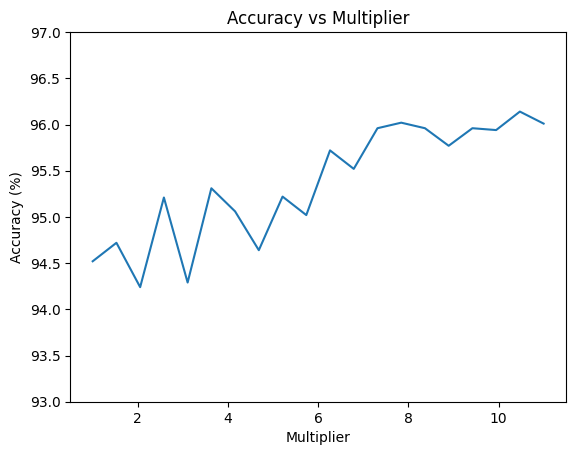

In [31]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(1, 11, 20), final_result)
plt.xlabel('Multiplier')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Multiplier')
plt.ylim([93, 97])
plt.show()